## Game Predictions

Import the necessary statements.

In [1]:
import pickle
import matplotlib.pyplot as plt
import numpy as np

To update the Elo ratings, uncomment and run both of the following lines. Click to view either the [Get2021Games](Get2021Games.ipynb) notebook or the [Update_Elo](Update_Elo.ipynb) notebook.

In [194]:
#%run ./Get2021Games.ipynb
#%run ./Update_Elo.ipynb

Load the updated dictionary with each team's ratings.

In [99]:
with open('EloRatings.pkl', 'rb')as f:
    eloDict = pickle.load(f)

In [100]:
eloDict

{'Bethel': 1435.2995309057765,
 'Goshen': 1313.2333869495922,
 'Grace': 1386.1186575656366,
 'HU': 1567.2950636023108,
 'IWU': 1694.6764184835217,
 'Marian': 1454.1036845194649,
 'MVNU': 1567.1946665439007,
 'SAU': 1444.771888674273,
 'SFU': 1518.3086200727123,
 'Taylor': 1618.9980826828119}

Here we build our fundamental function for updating ratings with each game that is played. We incorporate homefield advantage by adding `37.85` to each home team's rating. This was calculated by gathering data from the last 5 years (excluding 2020) and calculating the average win percentage of home teams. Given two 1500-rated teams, adding 37.85 to the home team most closely matched that average win percentage. Additionally, we incorporated a multiplier based on the margin of victory that increases from 1 by `0.05` per run. This formula was adapted from the one found at http://andr3w321.com/elo-ratings-part-1/.

In [101]:
def gamePlayed(winTeam, loseTeam, elo, winTeamLocation="N", marginOfVictory=1, k=20, tie=False): 
    if winTeamLocation == "H":
        rW = elo[winTeam] + 37.85 # get ratings
        rL = elo[loseTeam]
    elif winTeamLocation == "A":
        rW = elo[winTeam]
        rL = elo[loseTeam] + 37.85
    elif winTeamLocation == "N":
        rW = elo[winTeam]
        rL = elo[loseTeam]
    cW = 10 ** (rW/400)
    cL = 10 ** (rL/400)
    exp_winTeam = cW / float(cW + cL)
    exp_loseTeam = cL / float(cW + cL)
    if tie == True:
        s1 = 0.5
        s2 = 0.5
    else:
        s1 = 1
        s2 = 0
    if winTeamLocation == "H":
        new_rW = rW + k * (0.95 + 0.05*marginOfVictory) * (s1 - exp_winTeam) - 37.85
        new_rL = rL + k * (0.95 + 0.05*marginOfVictory) * (s2 - exp_loseTeam)
    elif winTeamLocation == "A":
        new_rW = rW + k * (0.95 + 0.05*marginOfVictory) * (s1 - exp_winTeam)
        new_rL = rL + k * (0.95 + 0.05*marginOfVictory) * (s2 - exp_loseTeam) - 37.85
    elif winTeamLocation == "N":
        new_rW = rW + k * (0.95 + 0.05*marginOfVictory) * (s1 - exp_winTeam)
        new_rL = rL + k * (0.95 + 0.05*marginOfVictory) * (s2 - exp_loseTeam)
    elo[winTeam] = new_rW
    elo[loseTeam] = new_rL

Next, we develop our function for calculating the likelihood of victory. Similarly, we incorporate homefield advantage. We have constructed the formula in such a way that we can compare two named teams, two numerical ratings, or one named team and one numerical rating. This formula was also adapted from http://andr3w321.com/elo-ratings-part-1/.

In [102]:
def expectGame(team1, team2, elo, Location1="N"):
    if type(team1) == str:
        if Location1 == "N" or Location1 == "A": r1 = elo[team1]
        elif Location1 == "H": r1 = elo[team1] + 37.85
    else:
        if Location1 == "N" or Location1 == "A": r1 = team1
        elif Location1 == "H": r1 = team1 + 37.85
    if type(team2) == str:
        if Location1 == "N" or Location1 == "H": r2 = elo[team2]
        elif Location1 == "A": r2 = elo[team2] + 37.85
    else:
        if Location1 == "N" or Location1 == "H": r2 = team2
        elif Location1 == "A": r2 = team2 + 37.85
    d = r1 - r2
    p = 1 - 1 / (1 + 10 ** (d / 400.0))
    return p

Now that we have our functions to update the Elo ratings and calculate the probability of victory, we write our functions to simulate each four-game series. Since there are four games with two possible outcomes each, there are $2^4$ or 16 total series outcomes. Our first model, the Elo simulation, must incorporate all possible outcomes. After each game, we keep record of the outcome's overall probability with the variable `p`. At the end of each outcome we accumulate the probabilities in the dictionary `t1wins` indexed 0-4 based on the number of wins earned by the first team provided. Before each simulated outcome, we reset the dictionary of Elo ratings to the original real ratings with the code `elo = eloDict.copy()`. 

In [103]:
def possibleOutcome(t1, t2, eloDict, w1, w2, w3, w4, t1wins):
    elo = eloDict.copy()
    p = 1
    games = [w1, w2, w3, w4]
    for game in games:
        if game == 1:
            p *= expectGame(t1, t2, elo)
            gamePlayed(t1, t2, elo)
        else:
            p *= expectGame(t2, t1, elo)
            gamePlayed(t2, t1, elo)
    t1wins[8-sum(games)] += p

Now that we have a function for each outcome, we nest loops for each game to account for all 16 possible outcomes and return `t1wins` to display the probabilites for 0, 1, 2, 3, or 4 wins by the first team listed.

In [104]:
def simSeriesElo(t1, t2, eloDict):
    t1wins = dict.fromkeys([0,1,2,3,4], 0)
    for g1 in range(1,3):
        for g2 in range(1,3):
            for g3 in range(1,3):
                for g4 in range(1,3):
                    possibleOutcome(t1, t2, eloDict, g1, g2, g3, g4, t1wins)
    return t1wins

Below is an example of this function with Grace and Huntington. First, we print out the probabilities for the number of games Grace will win. We also sum all of the values to show that the total probability of all the outcomes is 1.

In [105]:
GraceVsHU_elo = simSeriesElo("Grace", "HU", eloDict)
print(GraceVsHU_elo)
print(sum(GraceVsHU_elo.values()))

{0: 0.3259933071407519, 1: 0.3863860124564701, 2: 0.2133670473288128, 3: 0.06502954287457981, 4: 0.00922409019938536}
1.0


Our binomial simulation is much simpler. We take the probability `p` that the first team wins and probability `q` that the second team wins and use a simple binomial distribution with probability function $p(k) = \binom{n}{k} p^k \cdot q^{n-k}$ where $n = 4$ and $k$ represents the number of games won by the first team.

In [106]:
def simSeriesBinomial(t1, t2, elo):
    t1wins = dict.fromkeys([0,1,2,3,4], 0)
    p = expectGame(t1, t2, elo)
    q = expectGame(t2, t1, elo)
    t1wins[0] = q**4
    t1wins[1] = 4*(p)*(q**3)
    t1wins[2] = 6*(p**2)*(q**2)
    t1wins[3] = 4*(p**3)*(q)
    t1wins[4] = p**4
    return t1wins

Once again, we demonstrate this function with Grace and Huntington. Notice also that the probabilities sum to 1. 

In [107]:
GraceVsHU_bin = simSeriesBinomial("Grace","HU", eloDict)
print(GraceVsHU_bin)
print(sum(GraceVsHU_bin.values()))

{0: 0.29892021750513276, 1: 0.42138033670956504, 2: 0.22275348625727054, 3: 0.05233500086061504, 4: 0.004610958667416556}
1.0


In order to display our probabilities and highlight differences in the two simulations, we create a function to generate a bar graph that displays the probabilities for the two simulations side by side. 

In [108]:
def probsSideBySide(team1, team2, binProbs, eloProbs):
    N = 5
    bin_p = binProbs.values()
    elo_p = eloProbs.values()

    ind = np.arange(N) 
    width = 0.35       
    plt.bar(ind, bin_p, width, label='Binomial')
    plt.bar(ind + width, elo_p, width,
        label='Elo')

    plt.ylabel('Probabilities')
    plt.xlabel('Number of Wins')
    plt.title('Expected '+str(team1)+" Wins vs. "+str(team2))

    plt.xticks(ind + width / 2, (0,1,2,3,4))
    plt.legend(loc='best')
    plt.show()

We test this function with arbitrary teams and probabilities.

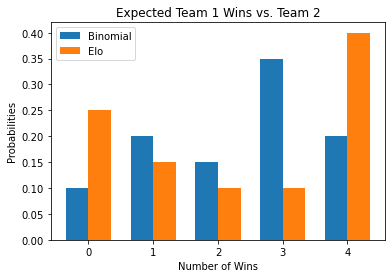

In [109]:
probsSideBySide("Team 1", "Team 2", {0:.1,1:.2,2:.15,3:.35,4:.2}, {0:.25,1:.15,2:.1,3:.1,4:.4})

Now that we have our necessary functions, we build a new function to run each simulation and generate a bar graph with predictions.

In [110]:
def predictSeries(team1, team2, eloDict):
    sim_elo = simSeriesElo(team1, team2, eloDict)
    sim_bin = simSeriesBinomial(team1, team2, eloDict)
    probsSideBySide(team1, team2, sim_bin, sim_elo)

In order to keep track of which simulation more accurately predicts the results, we will keep a list from every series indicating the more accurate simulation as well as by how much. Positive values indicate a better prediction by the Elo model and negative values indicate a better prediction by the binomial model. 

In [111]:
betterSim = []

The below function prints out which model has performed better over the course of the season up to that point.

In [112]:
def compareSims():
    if sum(betterSim)/len(betterSim) > 0:
        print("After this week, the Elo model has outperformed the binomial model this season by an average of "+str(round(sum(betterSim)/len(betterSim)*100, 2))+"%.")
    else:
        print("After this week, the binomial model has outperformed the Elo model this season by an average of "+str(round(sum(betterSim)/len(betterSim)*-100, 2))+"%.")

Finally, we develop a function to print out the probabilities from each simulation based on the actual results. We add an entry to the `betterSim` list quantifying which test outperformed the other. 

In [113]:
def printResults(team1, team2, t1wins, elo):
    winsElo = simSeriesElo(team1, team2, elo)
    print("Elo probability: "+str(round(winsElo[t1wins], 5)))
    winsBin = simSeriesBinomial(team1, team2, elo)
    print("Binomial probability: "+str(round(winsBin[t1wins], 5)))
    if winsBin[t1wins] > winsElo[t1wins]:
        print("The binomial simulation better predicted the results by "+str(round((winsBin[t1wins]-winsElo[t1wins])*100, 2))+"%.")
    else:
        print("The Elo simulation better predicted the results by "+str(round((winsElo[t1wins]-winsBin[t1wins])*100, 2))+"%.")
    betterSim.append(winsElo[t1wins]-winsBin[t1wins])

##### Weekend Games 3/12 - 3/13

We need to copy our Elo ratings for the current week of games as they will continue to update as the season goes on. To do this, we will pickle the dictionary onto a file that will not be changed with updating Elo ratings week to week and then immediately unpickle the file. Once we have pickled the file once, we comment out the code to ensure the pickle file does not get changed.

In [114]:
#eloWk2 = eloDict.copy()
#with open("eloWk2.pkl", "wb") as f:
    #pickle.dump(eloWk2, f)

In [115]:
with open("eloWk2.pkl", "rb") as f:
    eloWk2 = pickle.load(f)
eloWk2

{'Bethel': 1432.571963486864,
 'Goshen': 1450.385483229496,
 'Grace': 1485.8920376986255,
 'HU': 1542.013341082464,
 'IWU': 1557.7312585671455,
 'Marian': 1523.9959776208184,
 'MVNU': 1541.2211569401413,
 'SAU': 1495.8273064341213,
 'SFU': 1416.1551157644421,
 'Taylor': 1554.2063591758824}

Now we can run our simulations.

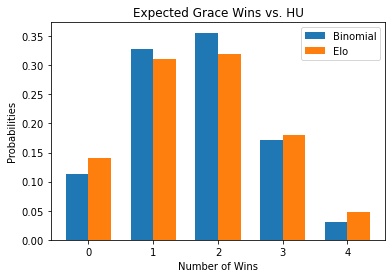

In [116]:
#Grace v HU
predictSeries("Grace","HU",eloWk2)

In [117]:
#Result: HU 3, Grace 1
printResults("Grace","HU",1,eloWk2)

Elo probability: 0.31159
Binomial probability: 0.32785
The binomial simulation better predicted the results by 1.63%.


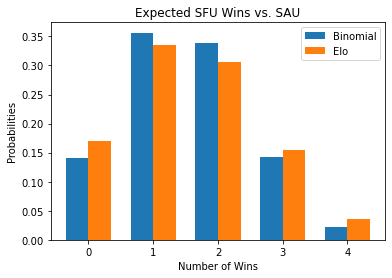

In [118]:
#SFU v SAU
predictSeries("SFU","SAU",eloWk2)

In [119]:
#Result: SFU 3, SAU 1
printResults("SFU","SAU",3,eloWk2)

Elo probability: 0.15384
Binomial probability: 0.14239
The Elo simulation better predicted the results by 1.14%.


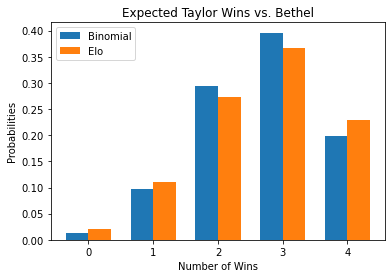

In [120]:
#Taylor v Bethel
predictSeries("Taylor","Bethel",eloWk2)

In [121]:
#Result: Taylor 4, Bethel 0
printResults("Taylor", "Bethel",4,eloWk2)

Elo probability: 0.22909
Binomial probability: 0.19939
The Elo simulation better predicted the results by 2.97%.


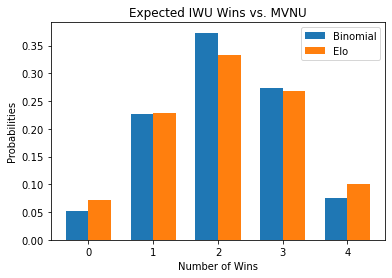

In [122]:
#IWU v MVNU
predictSeries("IWU","MVNU",eloWk2)

In [123]:
#Result: IWU 4, MVNU 0
printResults("IWU","MVNU",4,eloWk2)

Elo probability: 0.09981
Binomial probability: 0.07524
The Elo simulation better predicted the results by 2.46%.


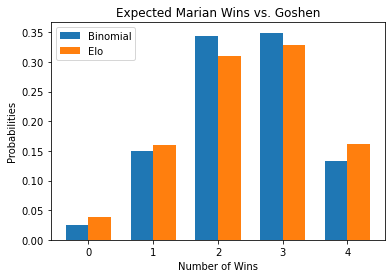

In [124]:
#Marian v Goshen
predictSeries("Marian","Goshen",eloWk2)

In [125]:
#Result: Marian 4, Goshen 0
printResults("Marian", "Goshen", 4, eloWk2)

Elo probability: 0.16231
Binomial probability: 0.13342
The Elo simulation better predicted the results by 2.89%.


Predictions:
- Grace 2, HU 2
- SAU 3, SFU 1
- Taylor 3, Bethel 1
- IWU 2, MVNU 2
- Marian 3, Goshen 1

Results:
- HU 3, Grace 1
- SFU 3, SAU 1
- Taylor 4, Bethel 0
- IWU 4, MVNU 0
- Marian 4, Goshen 0

In [126]:
compareSims()

After this week, the Elo model has outperformed the binomial model this season by an average of 1.57%.


##### Weekend Games 3/19 - 3/20

In [127]:
#eloWk3 = eloDict.copy()
#with open("eloWk3.pkl", "wb") as f:
    #pickle.dump(eloWk3, f)

In [128]:
with open("eloWk3.pkl", "rb") as f:
    eloWk3 = pickle.load(f)
eloWk3

{'Bethel': 1400.2147032104012,
 'Goshen': 1424.5888242889325,
 'Grace': 1466.7218352079278,
 'HU': 1561.1835435731616,
 'IWU': 1593.1147593654457,
 'Marian': 1552.4925126444925,
 'MVNU': 1483.1157461360804,
 'SAU': 1489.8219461064166,
 'SFU': 1444.8823860979076,
 'Taylor': 1583.8637433692345}

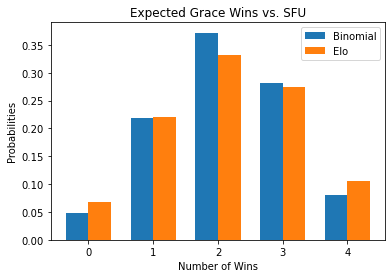

In [129]:
#Grace v SFU
predictSeries("Grace", "SFU", eloWk3)

In [130]:
#Result: Grace 1, SFU 3
printResults("Grace", "SFU", 1, eloWk3)

Elo probability: 0.22128
Binomial probability: 0.21873
The Elo simulation better predicted the results by 0.25%.


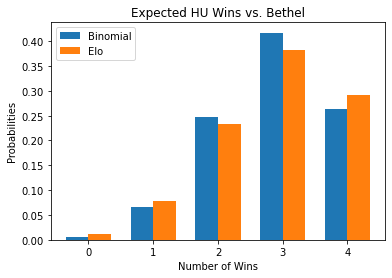

In [131]:
#HU v Bethel
predictSeries("HU", "Bethel", eloWk3)

In [132]:
#Result: HU 3, Bethel 1
printResults("HU", "Bethel", 3, eloWk3)

Elo probability: 0.38294
Binomial probability: 0.41709
The binomial simulation better predicted the results by 3.41%.


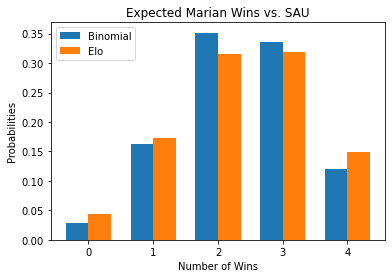

In [133]:
#Marian v SAU
predictSeries("Marian", "SAU", eloWk3)

In [134]:
#Result: Marian 3, SAU 1
printResults("Marian", "SAU", 3, eloWk3)

Elo probability: 0.31826
Binomial probability: 0.33613
The binomial simulation better predicted the results by 1.79%.


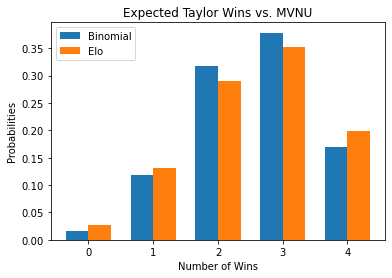

In [135]:
#Taylor v MVNU
predictSeries("Taylor", "MVNU", eloWk3)

In [136]:
#Result: Taylor 4, MVNU 0
printResults("Taylor", "MVNU", 4, eloWk3)

Elo probability: 0.19858
Binomial probability: 0.16888
The Elo simulation better predicted the results by 2.97%.


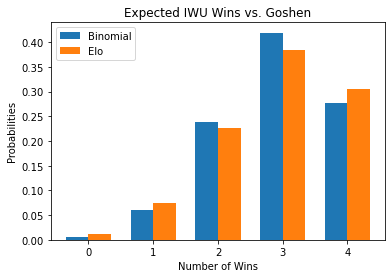

In [137]:
#IWU v Goshen
predictSeries("IWU","Goshen",eloWk3)

In [138]:
#Result: IWU 4, Goshen 0
printResults("IWU", "Goshen", 4, eloWk3)

Elo probability: 0.30442
Binomial probability: 0.2765
The Elo simulation better predicted the results by 2.79%.


Predictions:
- Grace 2, SFU 2
- HU 3, Bethel 1
- Marian 2, SAU 2 (Binomial)
- Marian 3, SAU 1 (Elo)
- Taylor 3, MVNU 1
- IWU 3, Goshen 1

Results:
- SFU 3, Grace 1
- HU 3, Bethel 1
- Marian 3, SAU 1
- Taylor 4, MVNU 0
- IWU 4, Goshen 0

In [139]:
compareSims()

After this week, the Elo model has outperformed the binomial model this season by an average of 0.86%.


##### Weekend Games 3/26 - 3/27

In [140]:
#eloWk4 = eloDict.copy()
#with open("eloWk4.pkl", "wb") as f:
    #pickle.dump(eloWk4, f)

In [141]:
with open("eloWk4.pkl", "rb") as f:
    eloWk4 = pickle.load(f)
eloWk4

{'Bethel': 1393.7860257348211,
 'Goshen': 1390.3152109015975,
 'Grace': 1434.6376645107598,
 'HU': 1567.6122210487417,
 'IWU': 1627.3883727527807,
 'Marian': 1561.5340998571191,
 'MVNU': 1457.8575811307321,
 'SAU': 1480.78035889379,
 'SFU': 1476.9665567950756,
 'Taylor': 1609.1219083745827}

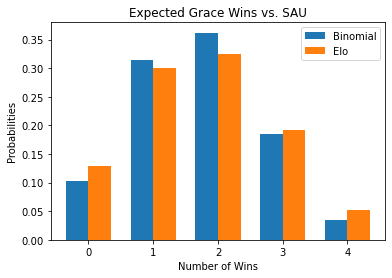

In [142]:
#Grace v SAU
predictSeries("Grace", "SAU", eloWk4)

In [143]:
#Results: Grace 1, SAU 3
printResults("Grace", "SAU", 1, eloWk4)

Elo probability: 0.30103
Binomial probability: 0.31479
The binomial simulation better predicted the results by 1.38%.


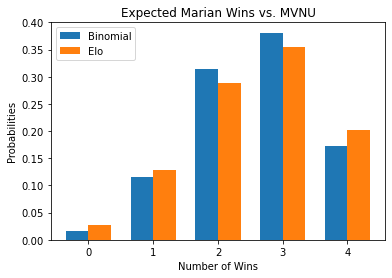

In [144]:
#Marian v MVNU
predictSeries("Marian", "MVNU", eloWk4)

In [145]:
#Result: Marian 0, MVNU 4
printResults("Marian", "MVNU", 0, eloWk4)

Elo probability: 0.02676
Binomial probability: 0.0159
The Elo simulation better predicted the results by 1.09%.


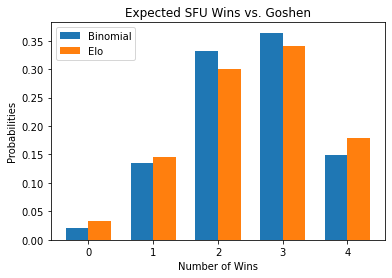

In [146]:
#SFU v Goshen
predictSeries("SFU", "Goshen", eloWk4)

In [147]:
#Result: SFU 4, Goshen 0
printResults("SFU", "Goshen", 4, eloWk4)

Elo probability: 0.17924
Binomial probability: 0.14985
The Elo simulation better predicted the results by 2.94%.


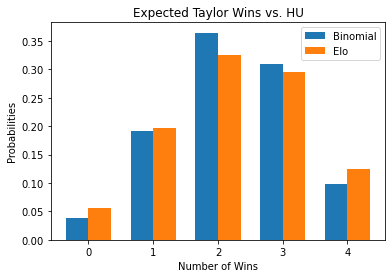

In [148]:
#Taylor v HU
predictSeries("Taylor", "HU", eloWk4)

In [149]:
#Result: Taylor 1, HU 3
printResults("Taylor", "HU", 1, eloWk4)

Elo probability: 0.19762
Binomial probability: 0.19134
The Elo simulation better predicted the results by 0.63%.


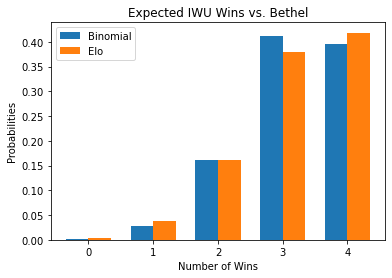

In [150]:
#IWU v Bethel
predictSeries("IWU", "Bethel", eloWk4)

In [151]:
#Result: IWU 3, Bethel 1
printResults("IWU", "Bethel", 3, eloWk4)

Elo probability: 0.37938
Binomial probability: 0.41279
The binomial simulation better predicted the results by 3.34%.


Predictions:
- Grace 2, SAU 2
- Marian 3, MVNU 1
- SFU 3, Goshen 1
- Taylor 2, HU 2
- IWU 3, Bethel 1 (Binomial)
- IWU 4, Bethel 0 (Elo)

Results
- SAU 3, Grace 1
- MVNU 4, Marian 0
- SFU 4, Goshen 0
- HU 3, Taylor 1
- IWU 3, Bethel 1

In [152]:
compareSims()

After this week, the Elo model has outperformed the binomial model this season by an average of 0.57%.


##### Weekend Games 4/2 - 4/3

In [153]:
#eloWk5 = eloDict.copy()
#with open("eloWk5.pkl", "wb") as f:
    #pickle.dump(eloWk5, f)

In [154]:
with open("eloWk5.pkl", "rb") as f:
    eloWk5 = pickle.load(f)
eloWk5

{'Bethel': 1389.1618139897193,
 'Goshen': 1351.8599921832003,
 'Grace': 1426.4857774319753,
 'HU': 1588.233008348279,
 'IWU': 1632.0125844978825,
 'Marian': 1510.0825141669973,
 'MVNU': 1509.309166820854,
 'SAU': 1488.9322459725745,
 'SFU': 1515.4217755134728,
 'Taylor': 1588.5011210750454}

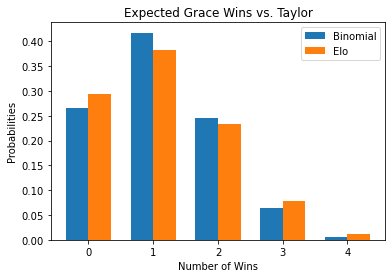

In [155]:
#Grace v Taylor
predictSeries("Grace", "Taylor", eloWk5)

In [156]:
#Result: Taylor 4, Grace 0
printResults("Grace", "Taylor", 0, eloWk5)

Elo probability: 0.29349
Binomial probability: 0.26519
The Elo simulation better predicted the results by 2.83%.


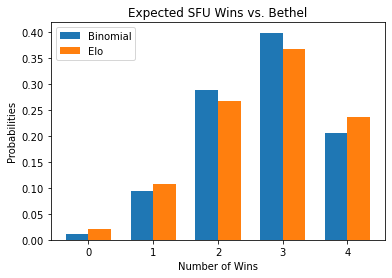

In [157]:
#SFU v Bethel
predictSeries("SFU", "Bethel", eloWk5)

In [158]:
#Result: SFU 3, Bethel 1
printResults("SFU", "Bethel", 3, eloWk5)

Elo probability: 0.36876
Binomial probability: 0.39932
The binomial simulation better predicted the results by 3.06%.


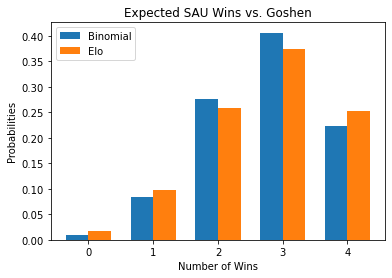

In [159]:
#SAU v Goshen
predictSeries("SAU", "Goshen", eloWk5)

In [160]:
#Result: SAU 2, Goshen 2
printResults("SAU", "Goshen", 2, eloWk5)

Elo probability: 0.2577
Binomial probability: 0.27682
The binomial simulation better predicted the results by 1.91%.


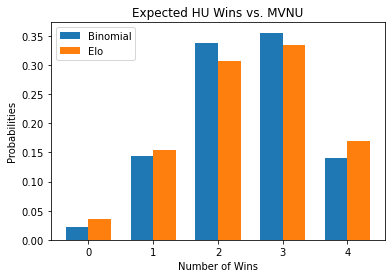

In [161]:
#HU v MVNU
predictSeries("HU", "MVNU", eloWk5)

In [162]:
#Result: HU 2, MVNU 2
printResults("HU", "MVNU", 2, eloWk5)

Elo probability: 0.30618
Binomial probability: 0.33852
The binomial simulation better predicted the results by 3.23%.


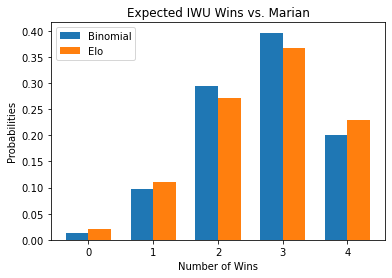

In [163]:
#IWU v Marian
predictSeries("IWU", "Marian", eloWk5)

In [164]:
#Result: IWU 3, Marian 1
printResults("IWU", "Marian", 3, eloWk5)

Elo probability: 0.36628
Binomial probability: 0.3962
The binomial simulation better predicted the results by 2.99%.


Predictions:
- Taylor 3, Grace 1
- SFU 3, Bethel 1
- SAU 3, Goshen 1
- HU 3, MVNU 1
- IWU 3, Marian 1

Results:
- Taylor 4, Grace 0
- SFU 3, Bethel 1
- SAU 2, Goshen 2
- HU 2, MVNU 2
- IWU 3, Marian 1

In [165]:
compareSims()

After this week, the Elo model has outperformed the binomial model this season by an average of 0.01%.


##### Weekend Games 4/9 - 4/10

In [166]:
#eloWk6 = eloDict.copy()
#with open("eloWk6.pkl", "wb") as f:
    #pickle.dump(eloWk6, f)

In [167]:
with open("eloWk6.pkl", "rb") as f:
    eloWk6 = pickle.load(f)
eloWk6

{'Bethel': 1393.4713772480557,
 'Goshen': 1359.9240774244577,
 'Grace': 1401.32249460395,
 'HU': 1578.8178983885505,
 'IWU': 1647.5284536028344,
 'Marian': 1494.5666450620454,
 'MVNU': 1518.7242767805826,
 'SAU': 1480.8681607313172,
 'SFU': 1511.1122122551365,
 'Taylor': 1613.6644039030707}

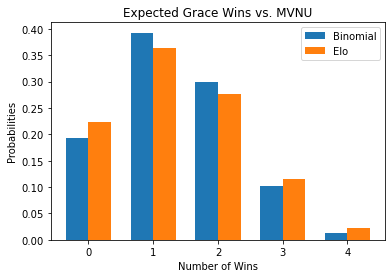

In [168]:
#Grace v MVNU
predictSeries("Grace", "MVNU", eloWk6)

In [169]:
#Result: Grace 0, MVNU 4
printResults("Grace", "MVNU", 0, eloWk6)

Elo probability: 0.22274
Binomial probability: 0.19299
The Elo simulation better predicted the results by 2.97%.


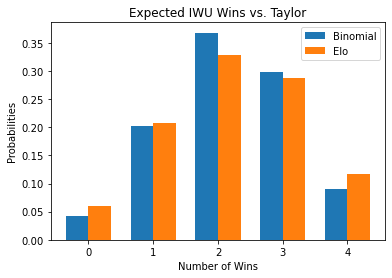

In [170]:
#IWU v Taylor
predictSeries("IWU", "Taylor", eloWk6)

In [171]:
#Result: IWU 3, Taylor 1
printResults("IWU", "Taylor", 3, eloWk6)

Elo probability: 0.28745
Binomial probability: 0.2981
The binomial simulation better predicted the results by 1.06%.


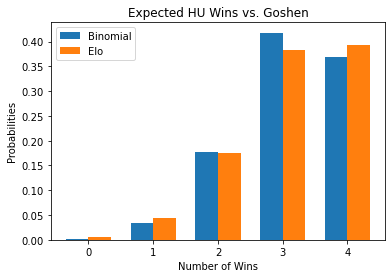

In [172]:
#HU v Goshen
predictSeries("HU", "Goshen", eloWk6)

In [173]:
#Result: HU 4, Goshen 0
printResults("HU", "Goshen", 4, eloWk6)

Elo probability: 0.39222
Binomial probability: 0.36832
The Elo simulation better predicted the results by 2.39%.


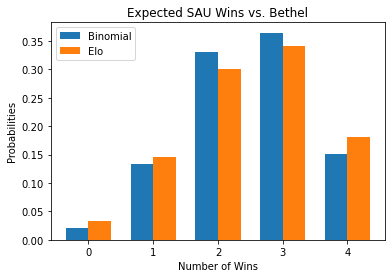

In [174]:
#SAU v Bethel
predictSeries("SAU", "Bethel", eloWk6)

In [175]:
#Result: SAU 2, Bethel 2
printResults("SAU", "Bethel", 2, eloWk6)

Elo probability: 0.30027
Binomial probability: 0.33086
The binomial simulation better predicted the results by 3.06%.


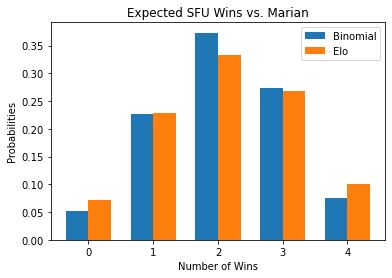

In [176]:
#SFU v Marian
predictSeries("SFU", "Marian", eloWk6)

In [177]:
#Results: SFU 4, Marian 0
printResults("SFU", "Marian", 4, eloWk6)

Elo probability: 0.09985
Binomial probability: 0.07527
The Elo simulation better predicted the results by 2.46%.


Predictions:
- MVNU 3, Grace 1
- IWU 2, Taylor 2
- HU 3, Goshen 1 (Binomial)
- HU 4, Goshen 0 (Elo)
- SAU 3, Bethel 1
- SFU 2, Marian 2

Results:
- MVNU 4, Grace 0
- IWU 3, Taylor 1
- HU 4, Goshen 0
- SAU 2, Bethel 2
- SFU 4, Marian 0

In [178]:
compareSims()

After this week, the Elo model has outperformed the binomial model this season by an average of 0.16%.


##### Weekend Games 4/16 - 4/17

In [179]:
#eloWk7 = eloDict.copy()
#with open("eloWk7.pkl", "wb") as f:
    #pickle.dump(eloWk7, f)

In [180]:
with open("eloWk7.pkl", "rb") as f:
    eloWk7 = pickle.load(f)
eloWk7

{'Bethel': 1406.2849409099742,
 'Goshen': 1342.6368272420575,
 'Grace': 1375.9977778517373,
 'HU': 1599.3159683629704,
 'IWU': 1665.7465446196961,
 'Marian': 1461.2992474442744,
 'MVNU': 1541.2420152901998,
 'SAU': 1467.9543747353475,
 'SFU': 1544.0031138218412,
 'Taylor': 1595.519189721902}

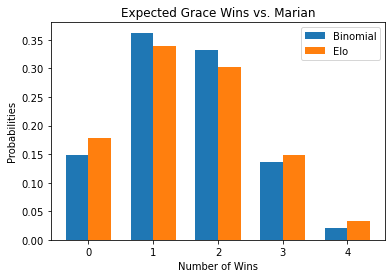

In [181]:
#Grace v Marian
predictSeries("Grace", "Marian", eloWk7)

In [182]:
#Result: Grace 2, Marian 2
printResults("Grace", "Marian", 2, eloWk7)

Elo probability: 0.30177
Binomial probability: 0.33281
The binomial simulation better predicted the results by 3.1%.


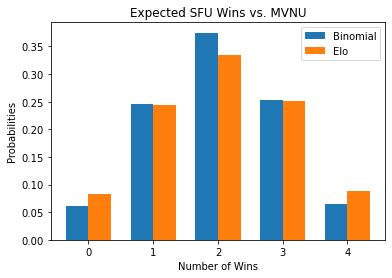

In [183]:
#SFU v MVNU
predictSeries("SFU", "MVNU", eloWk7)

In [184]:
#Result: MVNU 3, SFU 1
printResults("MVNU", "SFU", 3, eloWk7)

Elo probability: 0.24439
Binomial probability: 0.24603
The binomial simulation better predicted the results by 0.16%.


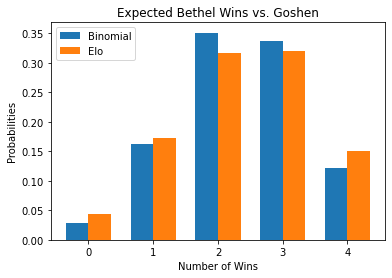

In [185]:
#Bethel v Goshen
predictSeries("Bethel", "Goshen", eloWk7)

In [186]:
#Result: Bethel 4, Goshen 0
printResults("Bethel", "Goshen", 4, eloWk7)

Elo probability: 0.15003
Binomial probability: 0.12166
The Elo simulation better predicted the results by 2.84%.


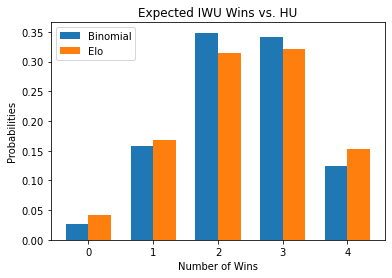

In [187]:
#IWU v HU
predictSeries("IWU", "HU", eloWk7)

In [188]:
#Result: IWU 4, HU 0
printResults("IWU", "HU", 4, eloWk7)

Elo probability: 0.1534
Binomial probability: 0.12487
The Elo simulation better predicted the results by 2.85%.


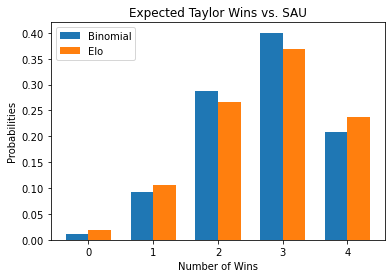

In [189]:
#Taylor v SAU
predictSeries("Taylor", "SAU", eloWk7)

In [190]:
#Result: Taylor 4, SAU 0
printResults("Taylor", "SAU", 4, eloWk7)

Elo probability: 0.23813
Binomial probability: 0.20852
The Elo simulation better predicted the results by 2.96%.


Predictions:
- Marian 3, Grace 1
- SFU 2, MVNU 2
- Bethel 2, Goshen 2 (Binomial)
- Bethel 3, Goshen 1 (Elo)
- IWU 2, HU 2 (Binomial)
- IWU 3, HU 1 (Elo)
- Taylor 3, SAU 1

Results:
- Marian 2, Grace 2
- MVNU 3, SFU 1
- Bethel 4, Goshen 0
- IWU 4, HU 0
- Taylor 4, SAU 0

In [191]:
compareSims()

After this week, the Elo model has outperformed the binomial model this season by an average of 0.31%.


##### Weekend Games 4/23 - 4/24

In [192]:
eloWk8 = eloDict.copy()
with open("eloWk8.pkl", "wb") as f:
    pickle.dump(eloWk8, f)

In [193]:
with open("eloWk8.pkl", "rb") as f:
    eloWk8 = pickle.load(f)
eloWk8

{'Bethel': 1435.2995309057765,
 'Goshen': 1313.2333869495922,
 'Grace': 1386.1186575656366,
 'HU': 1567.2950636023108,
 'IWU': 1694.6764184835217,
 'Marian': 1454.1036845194649,
 'MVNU': 1567.1946665439007,
 'SAU': 1444.771888674273,
 'SFU': 1518.3086200727123,
 'Taylor': 1618.9980826828119}

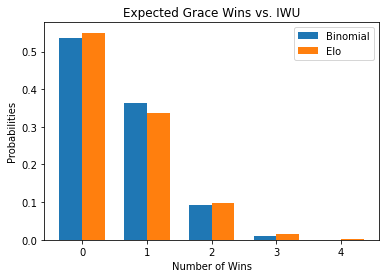

In [195]:
#Grace v IWU
predictSeries("Grace", "IWU", eloWk8)

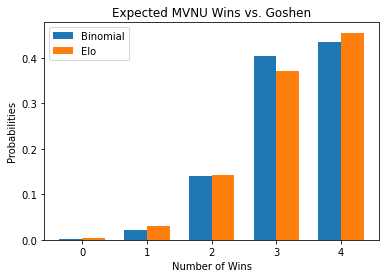

In [197]:
#MVNU v Goshen
predictSeries("MVNU", "Goshen", eloWk8)

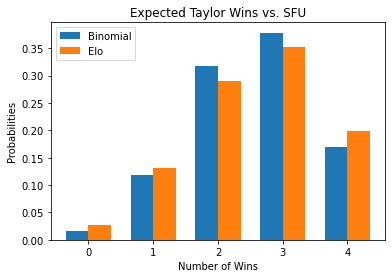

In [198]:
#Taylor v SFU
predictSeries("Taylor", "SFU", eloWk8)

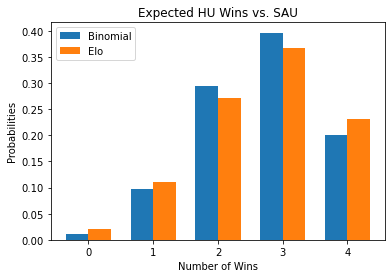

In [199]:
#HU v SAU
predictSeries("HU", "SAU", eloWk8)

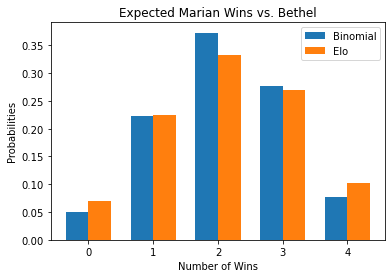

In [200]:
#Marian v Bethel
predictSeries("Marian", "Bethel", eloWk8)

Predictions:
- IWU 4, Grace 0
- MVNU 4, Goshen 0
- Taylor 3, SFU 1
- HU 3, SAU 1
- Marian 2, Bethel 2